# <p style="background-color:#B721FF;font-family:newtimeroman;color:#FFFFFF;font-size:150%;text-align:center;border-radius:20px 60px;">INTRODUCTION</p>
<p style="font-family:newtimeroman;font-size:120%;color:#444160;">This notebook contains complete walkthrough of our <b>2nd place</b> solution for SDS BIT Mesra - <i><b> ML Contest on Liver Disease Prediction.</b></i></p>
    
# <p style="background-color:#B721FF;font-family:newtimeroman;color:#FFFFFF;font-size:150%;text-align:center;border-radius:20px 60px;">HOW IT WILL BEGIN?</p>
<p style="font-family:newtimeroman;font-size:120%;color:#444160;"><b>Our aim is to a create very strong local CV. </b>We will start with creating folds. Then we will apply various feature engineering techniques and train several models each will have optimized hyperparameter like Catboost Classifier, GBM, LGBM, etc,. Then we  start filtering the models based on their <b>STABILITY</b>, this we will know by looking at the fold predictions. This is very crucial because if a model gives a very good score in one fold and very bad score in another then probably that model is not trustworthy and you would never want your final submission to be depended on that model. So we will filter models based on their stabilty. But here also everything will be modular so we will automatically get a nice pandas DATAFRAME which will contain each fold Accuracy score for all the models. To show here is the table containing info about each of our models.</p>

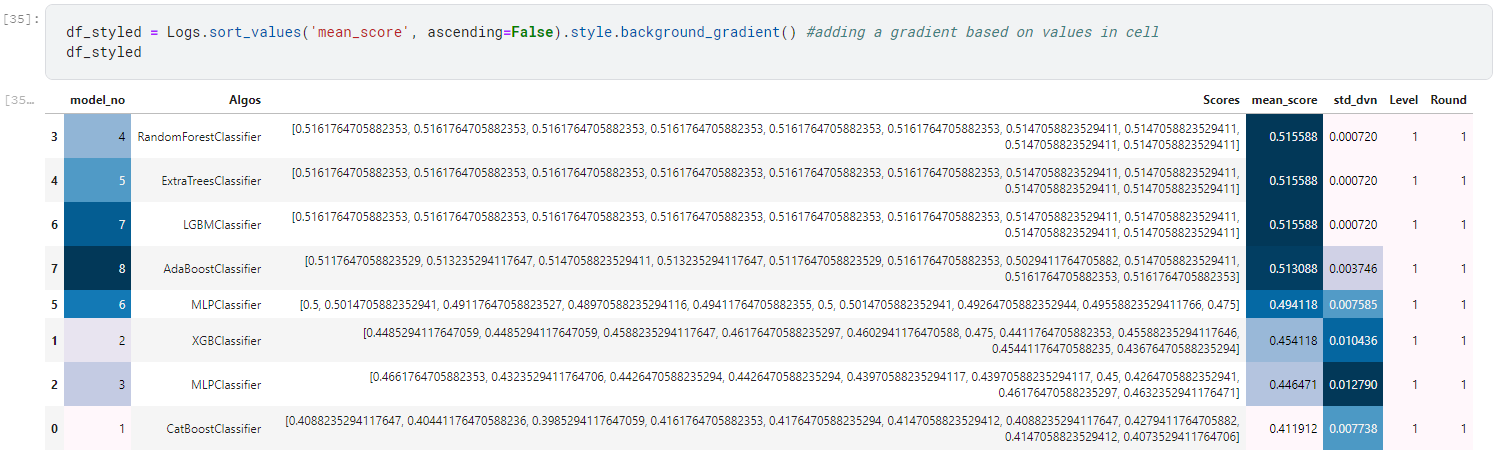
<p style="font-family:newtimeroman;font-size:120%;color:#444160;">This was all <b>Level 1</b> predictioins. Next we will use these predictions to create our <b>Level 2</b> predictions and then we will blend these results to get our final results. The final model we used is RandomForestClassifier. This we will do to avoid overfitting. Again our whole work can be shown in a diagram as this:-  </p>

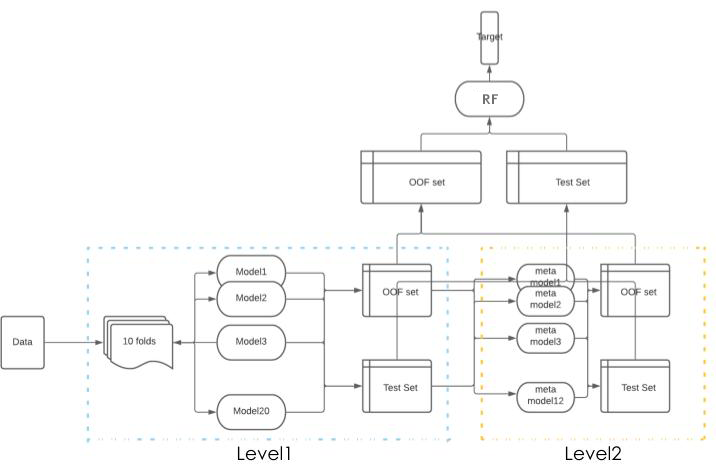
<p style="font-family:newtimeroman;font-size:120%;color:#444160;">This was a lot of work and finishing it in a single notebook wouldn't be possible so we broke down our work into different notebooks like optimization in one, blending in another , creating folds in another. Here we joined all the notebooks to give complete picture of what we did.</p>
<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#B721FF;font-family:newtimeroman;color:#FFFFFF;font-size:150%;text-align:center;border-radius:20px 60px;">TABLE OF CONTENTS</p>   
    
* [1. CREATE FOLDS](#1)
    
* [2. LEVELS](#2)
    
   * [2.1 LEVEL1](#2.1)
    
        * [2.1.a ROUND 1](#2.1.a)
        * [2.1.b ROUND 2](#2.1.b)
        * [2.1.c ROUND 3](#2.1.c)
    
   * [2.2 LEVEL2](#2.2)
        
        * [2.2.a ROUND 1](#2.2.a)
        * [2.2.b ROUND 2](#2.2.b)
    
    
* [3. FINAL MODEL](#3) 
    
* [4. END](#4)


<a id="0"></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#B721FF;font-family:newtimeroman;color:#FFFFFF;font-size:150%;text-align:center;border-radius:5px 5px;">LINKS TO THE NOTEBOOKS</p>
<p style="background-color:#B721FF;font-family:newtimeroman;color:#FFFFFF;font-size:150%;text-align:center;border-radius:20px 60px;">CREATE FOLDS</p> 
<p style="font-family:newtimeroman;font-size:120%;color:#444160;">Here we have splitted our training dataset into 10 folds.</p>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import random
import tensorflow as tf
import os
import gc
import psutil
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, Normalizer,MinMaxScaler,RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score,f1_score
from xgboost import XGBClassifier, XGBRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import PolynomialFeatures
from optuna.integration import LightGBMPruningCallback
# get skewed features to impute median instead of mean
from scipy import stats
from scipy.stats import skew
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn.linear_model import Ridge,Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from xgboost import XGBRegressor, XGBRFRegressor
import itertools
import optuna
from lightgbm import LGBMClassifier,LGBMRegressor
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
sns.set(style = "darkgrid")
%matplotlib inline
import time
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('float_format', '{:f}'.format)
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score,f1_score
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import KFold,StratifiedKFold

In [ ]:
#sample = pd.read_csv("../input/tabular-playground-series-feb-2022/sample_submission.csv")
train  = pd.read_csv("../input/liver-disease-competition/train_dataset.csv")
test = pd.read_csv("../input/liver-disease-competition/test_dataset.csv")

In [ ]:
# meta data
comp_name = 'liver_disease'
target_name = 'Stage'
id_name = 'ID'

In [ ]:
train.drop('Cholesterol',axis=1,inplace=True)  # because almost 44% nan value
test.drop('Cholesterol',axis=1,inplace=True)

train.drop('Tryglicerides',axis=1,inplace=True)  # because almost 40% nan value
test.drop('Tryglicerides',axis=1,inplace=True)

all_features = list(test.columns)[1:]

df = pd.concat([train[all_features], test[all_features]], axis=0)
dobj = df.select_dtypes(['object'])
obj_cols= dobj.columns

train[obj_cols]= train[obj_cols].fillna(value=train[obj_cols].mode().iloc[0,:])
test[obj_cols]= test[obj_cols].fillna(value=test[obj_cols].mode().iloc[0,:])

dobj = df.select_dtypes(exclude=['object'])
int_cols = dobj.columns

int_cols1 = ['Albumin','Platelets']
int_cols2 = list(set(int_cols)- set(int_cols1))

train[int_cols1]= train[int_cols1].fillna(value=train[int_cols1].mean())
train[int_cols2]= train[int_cols2].fillna(value=train[int_cols2].mode().iloc[0,:])

test[int_cols1]= test[int_cols1].fillna(value=test[int_cols1].mean())
test[int_cols2]= test[int_cols2].fillna(value=test[int_cols2].mode().iloc[0,:])

train['Bilirubin_modified'] = train['Bilirubin'] * 88.4
test['Bilirubin_modified'] = test['Bilirubin'] * 88.4

train['normal_Bilirubin'] = ((train.Bilirubin_modified <= 20) & (1 <= train.Bilirubin_modified)).astype(int)
test['normal_Bilirubin'] = ((test.Bilirubin_modified <= 20) & (1 <= test.Bilirubin_modified)).astype(int)

train['Albumin_modified'] = train['Albumin']* 10
test['Albumin_modified'] = test['Albumin']* 10

train['normal_Albumin'] = ((train.Albumin_modified <= 44) &  (train.Albumin_modified >= 32)).astype(int)
test['normal_Albumin'] = ((test.Albumin_modified <= 44) &  (test.Albumin_modified >= 32)).astype(int)

train['normal_Alk_Phos']  =  ((train['Alk_Phos'] <= 140 ) & (train['Alk_Phos'] >= 35 )).astype(int)
test['normal_Alk_Phos']  =  ((test['Alk_Phos'] <= 140 ) & (test['Alk_Phos'] >= 35 )).astype(int)

train['SGOT_modified'] = train['SGOT']* 1000
test['SGOT_modified'] = test['SGOT']* 1000

train['normal_SGOT']  =  ((train['SGOT_modified'] <= 30 ) & (train['SGOT_modified'] >= 5 )).astype(int)
test['normal_SGOT']  =  ((test['SGOT_modified'] <= 30 ) & (test['SGOT_modified'] >= 5 )).astype(int)

# Let's drop duplicates
duplicate_cols = ['Bilirubin','Albumin','SGOT'] # we didn't create Alk_Phos_modified
test.drop(duplicate_cols, axis=1,inplace=True)
train.drop(duplicate_cols, axis=1,inplace=True)

useful_cols = test.drop("ID",axis=1).columns

t = test.select_dtypes(['object'])
obj_cols = t.columns

train['isTrain'] = 1
test['isTrain'] = 0

df = pd.concat([train,test])

df['Age_bins']= pd.cut(df.Age.astype(int), 5)

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
label = LabelEncoder()
df['Age_bins']=label.fit_transform(df['Age_bins'])

df= pd.get_dummies(data= df,columns=obj_cols,drop_first= True)

train = df[df.isTrain == 1]
test = df[df.isTrain == 0]

train.drop('isTrain', axis= 1,inplace=True)
test.drop(['isTrain','Stage'], axis=1, inplace=True)
useful_features = test.drop('ID',axis=1).columns.tolist()

my_folds = train.copy()
my_folds['Stage'].value_counts()  # we see it is unbalanced so we will use Stratified kfold
#------------------------------ do it together to maintain same split
import os
import random
import tensorflow as tf
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    #torch.manual_seed(seed)
seed_everything(17)
print(np.random.randint(3,10)) # it should return 4

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=21)
#-----------------------------------
for fold, (train_indices, valid_indices) in enumerate(skf.split(my_folds,my_folds.Stage)):
    #print(fold)
    my_folds.loc[valid_indices,'fold'] = fold
my_folds.fold = my_folds.fold.astype(int) # convert fold column to int types
useful_featurs = test.drop('ID',axis=1).columns.tolist()
len(useful_features)
#test = test[useful_features].copy()
#--------------------------------LGBM
useful_features = ['Albumin_modified', 'Platelets', 'Age', 'N_Days', 'Alk_Phos', 'Copper', 'Prothrombin', 'Bilirubin_modified', 'SGOT_modified', 'Status_D', 'Drug_Placebo', 'Hepatomegaly_Y', 'Edema_S', 'Sex_M', 'Ascites_Y', 'Spiders_Y', 'Status_CL', 'Edema_Y', 'Age_bins']
test = test[['ID']+ useful_features  ]
my_folds = my_folds[['ID']+ useful_features +['Stage','fold']]

<p style="font-family:newtimeroman;font-size:120%;color:#444160;">For detailed explanation on the approach you can check these two notebooks. <br>
📌Link of Liver Disease | EDA <a href="https://www.kaggle.com/raj401/liver-disease-eda/notebook">https://www.kaggle.com/raj401/liver-disease-eda/notebook</a><br>
📌Link of notebook where we have created folds <a href="https://www.kaggle.com/raj401/liverdisease-create-folds/notebook">https://www.kaggle.com/raj401/liverdisease-create-folds/notebook</a><br></p>

In [ ]:
my_folds.columns

In [ ]:
test.columns

In [ ]:
print(my_folds.shape, test.shape, len(useful_features))

In [ ]:
my_folds.to_csv("Liver_disease_Folds.csv",index=False)
test.to_csv("test_updated.csv", index=False)

<a id=2></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#B721FF;font-family:newtimeroman;color:#FFFFFF;font-size:150%;text-align:center;border-radius:20px 60px;">LEVELS</p> 
    <p style="font-family:newtimeroman;font-size:120%;color:#444160;">As discussed earlier we will be creating two levels LEVEL1 and LEVEL2. In each level we will create several rounds called as ROUND1, ROUND2, ROUND3...
<br>Each round will have different set of feature engineering. We will find optimal hyperparameters of all the models in each round using OPTUNA. This is a lot of work and probably would much time to run in a single notebook so we have did it in parts like each Level/each optimization has been done in seprate notebook. For the completeness of our work we have put all this code here in single notebook.</p>


<a id=2.1></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#FBAB7E;font-family:newtimeroman;color:#FFFFFF;font-size:150%;text-align:center;border-radius:20px 20px;">LEVEL1</p> 

<a id=2.1.1></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:FBAB7E;font-family:newtimeroman;color:#444160;font-size:150%;text-align:left;border-radius:20px 20px;">ROUND1</p> 
<p style="font-family:newtimeroman;font-size:120%;color:#444160;">PREPROCESSING (We will go with default settings)<br>Features selected for training :- <code>[ 'Albumin_modified', 'Platelets', 'Age', 'N_Days', 'Alk_Phos',
       'Copper', 'Prothrombin', 'Bilirubin_modified', 'SGOT_modified',
       'Status_D', 'Drug_Placebo', 'Hepatomegaly_Y', 'Edema_S', 'Sex_M',
       'Ascites_Y', 'Spiders_Y', 'Status_CL', 'Edema_Y', 'Age_bins']</code><br>
    Scaler :- <code>MinMaxScaler()</code></p>

### <p style="font-family:newtimeroman;font-size:120%;color:#444160;">1. Catboost-Classifier :- </p> 

In [ ]:
Level = 1
Round = 1
comp_name = 'LD'
target_name = 'Stage'
id_name = 'ID'
random_st = 11

In [ ]:
train_data = my_folds.copy()
test_data = test.copy()

In [ ]:
t = ['ID','Albumin_modified', 'Platelets', 'Age', 'N_Days', 'Alk_Phos', 'Copper',
       'Prothrombin', 'Bilirubin_modified', 'SGOT_modified', 'Status_D',
       'Drug_Placebo', 'Hepatomegaly_Y', 'Edema_S', 'Sex_M', 'Ascites_Y',
       'Spiders_Y', 'Status_CL', 'Edema_Y', 'Age_bins']
test_data= test_data[t] # to reorder bring ID to front
test_data.head(2)

In [ ]:
train_data= train_data[test_data.columns.tolist() + ['Stage','fold']]
train_data.head(2)

In [ ]:
train_data.shape, test_data.shape

In [ ]:
#---
useful_features = test_data.drop("ID",axis= 1).columns.tolist()
test = test_data.copy()
my_folds = train_data.copy()

In [ ]:
print(test.shape, my_folds.shape, len(useful_features))

In [ ]:
print(useful_features)

In [ ]:
def obj(trial,xtrain,ytrain,xvalid,yvalid):
    
    params = {
        'iterations':trial.suggest_int("iterations", 300, 1200),
        'objective': trial.suggest_categorical('objective', ['MultiClass']),
        #'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli']),
        #'od_wait':trial.suggest_int('od_wait', 500, 2000),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.02,1),
        #'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
        
#         'random_strength': trial.suggest_uniform('random_strength',10,50),
#         'depth': trial.suggest_int('depth',1,15),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
#         'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'verbose': False,
        'task_type' : 'GPU',
        'devices' : '0'
    } 
        
        
    model = CatBoostClassifier(**params,loss_function='MultiClass',random_state=random_st ) #, device_type='gpu')
    model.fit(xtrain, ytrain)
    
    valid_preds = model.predict(xvalid)
    #test_preds = model.predict(xtest)
    #score = accuracy_score(yvalid, valid_preds)  # since it is a classification problem so we will use roc auc score
    score= f1_score(yvalid, valid_preds,average= 'weighted' )

    return score

# create trial function
def run(my_folds1):   
 
    my_folds1 = my_folds.copy()
    #test1  = test.copy()

    fold=0
    xtrain = my_folds[my_folds1.fold != fold].reset_index(drop=True)
    xvalid = my_folds[my_folds1.fold == fold].reset_index(drop=True)
    #xtest = test1.copy()

    ytrain = xtrain[target_name]
    yvalid = xvalid[target_name]

    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]

    ## preprocess
    si = SimpleImputer(strategy='median')
    xtrain = si.fit_transform(xtrain)
    xvalid = si.transform(xvalid)
    #xtest = si.transform(xtest)

    # scale
    ss = RobustScaler()
    xtrain = ss.fit_transform(xtrain)
    xvalid = ss.transform(xvalid)
    #xtest = ss.transform(xtest)

    xtrain = pd.DataFrame(xtrain, columns=useful_features)
    xvalid = pd.DataFrame(xvalid, columns=useful_features)
    #xtest = pd.DataFrame(xtest, columns=useful_features)
    
#     for col in useful_features:
#         xtrain[col] = np.log1p(xtrain[col])
#         xvalid[col] = np.log1p(xvalid[col])
#         #xtest[col] = np.log1p(xtest[col])
        
    #create optuna study
    study = optuna.create_study(
        direction='maximize',
        study_name='CATboost_c'
    )

    study.optimize( lambda trial: obj(trial,xtrain,ytrain,xvalid,yvalid),n_trials= 50 ) # it tries 50 different values to find optimal hyperparameter

    print(f"Best Params: {study.best_trial.params}")
    print(f"Best Trial: {study.best_trial.value}")
    
    return study

In [ ]:
study=run(my_folds)

In [ ]:
#optuna.visualization.plot_param_importances(study)

In [ ]:
bp= study.best_trial.params
bp

In [ ]:
bv= study.best_trial.value
bv

In [ ]:
param1 = {'iterations': 635,
 'objective': 'MultiClass',
 'learning_rate': 0.9518213414052558}

### <p style="font-family:newtimeroman;font-size:120%;color:#444160;">2. XGBClassifier :- </p>

In [ ]:
Level = 1
Round = 1
random_st = 11

In [ ]:
def obj(trial,xtrain,ytrain,xvalid,yvalid):
    
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 10000, 100),
        'eta': trial.suggest_discrete_uniform('eta', 0.01, 0.1, 0.01),
        'reg_alpha': trial.suggest_int('reg_alpha', 1, 50),
        'reg_lambda': trial.suggest_int('reg_lambda', 5, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 20),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
    }
        
        
    model = XGBClassifier( tree_method='gpu_hist', 
                             gpu_id=0, 
                             predictor="gpu_predictor"
                             ,**params, random_state=random_st)

    model.fit(xtrain, ytrain,eval_set=[(xvalid,yvalid)], early_stopping_rounds=150,verbose=False)
    model.fit(xtrain, ytrain)
    
    valid_preds = model.predict(xvalid)
    #test_preds = model.predict(xtest)
    #score = accuracy_score(yvalid, valid_preds)  # since it is a classification problem so we will use roc auc score
    score= f1_score(yvalid, valid_preds,average= 'weighted' )

    return score

# create trial function
def run(my_folds1):   
 
    my_folds1 = my_folds.copy()
    #test1  = test.copy()

    fold=0
    xtrain = my_folds[my_folds1.fold != fold].reset_index(drop=True)
    xvalid = my_folds[my_folds1.fold == fold].reset_index(drop=True)
    #xtest = test1.copy()

    ytrain = xtrain[target_name]
    yvalid = xvalid[target_name]

    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]

    ## preprocess
    si = SimpleImputer(strategy='median')
    xtrain = si.fit_transform(xtrain)
    xvalid = si.transform(xvalid)
    #xtest = si.transform(xtest)

    # scale
    ss = RobustScaler()
    xtrain = ss.fit_transform(xtrain)
    xvalid = ss.transform(xvalid)
    #xtest = ss.transform(xtest)

    xtrain = pd.DataFrame(xtrain, columns=useful_features)
    xvalid = pd.DataFrame(xvalid, columns=useful_features)
    #xtest = pd.DataFrame(xtest, columns=useful_features)
    
#     for col in useful_features:
#         xtrain[col] = np.log1p(xtrain[col])
#         xvalid[col] = np.log1p(xvalid[col])
#         #xtest[col] = np.log1p(xtest[col])
        
    #create optuna study
    study = optuna.create_study(
        direction='maximize',
        study_name='CATboost_c'
    )

    study.optimize( lambda trial: obj(trial,xtrain,ytrain,xvalid,yvalid),n_trials= 50 ) # it tries 50 different values to find optimal hyperparameter

    print(f"Best Params: {study.best_trial.params}")
    print(f"Best Trial: {study.best_trial.value}")
    
    return study

In [ ]:
study=run(my_folds)

In [ ]:
#optuna.visualization.plot_param_importances(study)

In [ ]:
bp= study.best_trial.params
bp

In [ ]:
bv= study.best_trial.value
bv

In [ ]:
param2 = {'max_depth': 8,
 'subsample': 0.85,
 'n_estimators': 4100,
 'eta': 0.06999999999999999,
 'reg_alpha': 7,
 'reg_lambda': 73,
 'min_child_weight': 11,
 'colsample_bytree': 0.5727746364961211}

### <p style="font-family:newtimeroman;font-size:120%;color:#444160;">3. MLPClassifier:- </p>

In [ ]:
def obj(trial,xtrain,ytrain,xvalid,yvalid):
    
    params = {
        "learning_rate": trial.suggest_categorical("learning_rate",['constant','invscaling','adaptive']),
        "hidden_layer_sizes": trial.suggest_categorical("hidden_layer_sizes",[(5,10,5),(20,10),(10,20),(50,50),(100,100)]),
        "alpha": trial.suggest_categorical("alpha",[.3,.1,.01,.001,.0001]),
        "activation": trial.suggest_categorical("activation",['relu','tanh']),
        #"solver": trial.suggest_categorical("solver",['lbfgs'])
    } 
    model = MLPClassifier(**params,random_state=random_st)
    model.fit(xtrain, ytrain)
    
    valid_preds = model.predict(xvalid)
    #test_preds = model.predict(xtest)
    #score = accuracy_score(yvalid, valid_preds)  # since it is a classification problem so we will use roc auc score
    score= f1_score(yvalid, valid_preds,average= 'weighted' )

    return score

# create trial function
def run(my_folds1):   
 
    my_folds1 = my_folds.copy()
    #test1  = test.copy()

    fold=0
    xtrain = my_folds[my_folds1.fold != fold].reset_index(drop=True)
    xvalid = my_folds[my_folds1.fold == fold].reset_index(drop=True)
    #xtest = test1.copy()

    ytrain = xtrain[target_name]
    yvalid = xvalid[target_name]

    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]

    ## preprocess
    si = SimpleImputer(strategy='median')
    xtrain = si.fit_transform(xtrain)
    xvalid = si.transform(xvalid)
    #xtest = si.transform(xtest)

    # scale
    ss = RobustScaler()
    xtrain = ss.fit_transform(xtrain)
    xvalid = ss.transform(xvalid)
    #xtest = ss.transform(xtest)

    xtrain = pd.DataFrame(xtrain, columns=useful_features)
    xvalid = pd.DataFrame(xvalid, columns=useful_features)
    #xtest = pd.DataFrame(xtest, columns=useful_features)
    
#     for col in useful_features:
#         xtrain[col] = np.log1p(xtrain[col])
#         xvalid[col] = np.log1p(xvalid[col])
#         #xtest[col] = np.log1p(xtest[col])
        
    #create optuna study
    study = optuna.create_study(
        direction='maximize',
        study_name='CATboost_c'
    )

    study.optimize( lambda trial: obj(trial,xtrain,ytrain,xvalid,yvalid),n_trials= 50 ) # it tries 50 different values to find optimal hyperparameter

    print(f"Best Params: {study.best_trial.params}")
    print(f"Best Trial: {study.best_trial.value}")
    
    return study

In [ ]:
study=run(my_folds)

In [ ]:
#optuna.visualization.plot_param_importances(study)

In [ ]:
bp= study.best_trial.params
bp

In [ ]:
bv= study.best_trial.value
bv

In [ ]:
param3 = {'learning_rate': 'adaptive',
 'hidden_layer_sizes': (50, 50),
 'alpha': 0.0001,
 'activation': 'tanh'}

### <p style="font-family:newtimeroman;font-size:120%;color:#444160;">4. Random Forest Classifier</p>

In [ ]:
def obj(trial,xtrain,ytrain,xvalid,yvalid):
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 4, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 150),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 60),
    }


    model = RandomForestClassifier(random_state=random_st, **params)
    model.fit(xtrain, ytrain)
    
    valid_preds = model.predict(xvalid)
    #test_preds = model.predict(xtest)
    #score = accuracy_score(yvalid, valid_preds)  # since it is a classification problem so we will use roc auc score
    score= f1_score(yvalid, valid_preds,average= 'weighted' )

    return score

# create trial function
def run(my_folds1):   
 
    my_folds1 = my_folds.copy()
    #test1  = test.copy()

    fold=0
    xtrain = my_folds[my_folds1.fold != fold].reset_index(drop=True)
    xvalid = my_folds[my_folds1.fold == fold].reset_index(drop=True)
    #xtest = test1.copy()

    ytrain = xtrain[target_name]
    yvalid = xvalid[target_name]

    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]

    ## preprocess
    si = SimpleImputer(strategy='median')
    xtrain = si.fit_transform(xtrain)
    xvalid = si.transform(xvalid)
    #xtest = si.transform(xtest)

    # scale
    ss = RobustScaler()
    xtrain = ss.fit_transform(xtrain)
    xvalid = ss.transform(xvalid)
    #xtest = ss.transform(xtest)

    xtrain = pd.DataFrame(xtrain, columns=useful_features)
    xvalid = pd.DataFrame(xvalid, columns=useful_features)
    #xtest = pd.DataFrame(xtest, columns=useful_features)
    
#     for col in useful_features:
#         xtrain[col] = np.log1p(xtrain[col])
#         xvalid[col] = np.log1p(xvalid[col])
#         #xtest[col] = np.log1p(xtest[col])
        
    #create optuna study
    study = optuna.create_study(
        direction='maximize',
        study_name='CATboost_c'
    )

    study.optimize( lambda trial: obj(trial,xtrain,ytrain,xvalid,yvalid),n_trials= 50 ) # it tries 50 different values to find optimal hyperparameter

    print(f"Best Params: {study.best_trial.params}")
    print(f"Best Trial: {study.best_trial.value}")
    
    return study

In [ ]:
study=run(my_folds)

In [ ]:
#optuna.visualization.plot_param_importances(study)

In [ ]:
bp= study.best_trial.params
bp

In [ ]:
bv= study.best_trial.value
bv

In [ ]:
param4 = {'n_estimators': 487,
 'max_depth': 10,
 'min_samples_split': 17,
 'min_samples_leaf': 38}

### <p style="font-family:newtimeroman;font-size:120%;color:#444160;">5. Extra Tree classifier</p>

In [ ]:
def obj(trial,xtrain,ytrain,xvalid,yvalid):
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators',  50, 1000),
        'max_depth': trial.suggest_int('max_depth', 4,50),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 15, 25),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
    }

    model = ExtraTreesClassifier(random_state=random_st, **params)
    model.fit(xtrain, ytrain)
    
    valid_preds = model.predict(xvalid)
    #test_preds = model.predict(xtest)
    #score = accuracy_score(yvalid, valid_preds)  # since it is a classification problem so we will use roc auc score
    score= f1_score(yvalid, valid_preds,average= 'weighted' )

    return score

# create trial function
def run(my_folds1):   
 
    my_folds1 = my_folds.copy()
    #test1  = test.copy()

    fold=0
    xtrain = my_folds[my_folds1.fold != fold].reset_index(drop=True)
    xvalid = my_folds[my_folds1.fold == fold].reset_index(drop=True)
    #xtest = test1.copy()

    ytrain = xtrain[target_name]
    yvalid = xvalid[target_name]

    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]

    ## preprocess
    si = SimpleImputer(strategy='median')
    xtrain = si.fit_transform(xtrain)
    xvalid = si.transform(xvalid)
    #xtest = si.transform(xtest)

    # scale
    ss = RobustScaler()
    xtrain = ss.fit_transform(xtrain)
    xvalid = ss.transform(xvalid)
    #xtest = ss.transform(xtest)

    xtrain = pd.DataFrame(xtrain, columns=useful_features)
    xvalid = pd.DataFrame(xvalid, columns=useful_features)
    #xtest = pd.DataFrame(xtest, columns=useful_features)
    
#     for col in useful_features:
#         xtrain[col] = np.log1p(xtrain[col])
#         xvalid[col] = np.log1p(xvalid[col])
#         #xtest[col] = np.log1p(xtest[col])
        
    #create optuna study
    study = optuna.create_study(
        direction='maximize',
        study_name='CATboost_c'
    )

    study.optimize( lambda trial: obj(trial,xtrain,ytrain,xvalid,yvalid),n_trials= 50 ) # it tries 50 different values to find optimal hyperparameter

    print(f"Best Params: {study.best_trial.params}")
    print(f"Best Trial: {study.best_trial.value}")
    
    return study

In [ ]:
study=run(my_folds)

In [ ]:
#optuna.visualization.plot_param_importances(study)

In [ ]:
bp= study.best_trial.params
bp

In [ ]:
bv= study.best_trial.value
bv

In [ ]:
param5 = {'n_estimators': 824,
 'max_depth': 20,
 'max_leaf_nodes': 17,
 'criterion': 'entropy'}

### <p style="font-family:newtimeroman;font-size:120%;color:#444160;">6. MLPClassifier2</p>

In [ ]:
def obj(trial,xtrain,ytrain,xvalid,yvalid):
    
    params = {
        "learning_rate": trial.suggest_categorical("learning_rate",['constant','invscaling','adaptive']),
        #"hidden_layer_sizes": trial.suggest_categorical("hidden_layer_sizes",[(5,10,5),(20,10),(10,20),(50,50),(100,100)]),
        "alpha": trial.suggest_categorical("alpha",[.3,.1,.01,.001,.0001]),
        "activation": trial.suggest_categorical("activation",['relu','tanh']),
        "primes": trial.suggest_categorical("primes",[2,3,5,7,11,13,17,19,23,29,31])
        #"solver": trial.suggest_categorical("solver",['lbfgs'])
    } 
    no_cols = xvalid.shape[1]
    hidden_layer_sizes = []
    print(params['primes'])
    while no_cols != 0:
        hidden_layer_sizes.append(no_cols)
        no_cols = int(no_cols// params['primes'])
    params.update({'hidden_layer_sizes':hidden_layer_sizes})
    del params['primes']
    print(params)
    
    model = MLPClassifier(**params,random_state=random_st)
    model.fit(xtrain, ytrain)
    
    
    valid_preds = model.predict(xvalid)
    #test_preds = model.predict(xtest)
    #score = accuracy_score(yvalid, valid_preds)  # since it is a classification problem so we will use roc auc score
    score= f1_score(yvalid, valid_preds,average= 'weighted' )

    return score

# create trial function
def run(my_folds1):   
 
    my_folds1 = my_folds.copy()
    #test1  = test.copy()

    fold=0
    xtrain = my_folds[my_folds1.fold != fold].reset_index(drop=True)
    xvalid = my_folds[my_folds1.fold == fold].reset_index(drop=True)
    #xtest = test1.copy()

    ytrain = xtrain[target_name]
    yvalid = xvalid[target_name]

    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]

    ## preprocess
    si = SimpleImputer(strategy='median')
    xtrain = si.fit_transform(xtrain)
    xvalid = si.transform(xvalid)
    #xtest = si.transform(xtest)

    # scale
    ss = RobustScaler()
    xtrain = ss.fit_transform(xtrain)
    xvalid = ss.transform(xvalid)
    #xtest = ss.transform(xtest)

    xtrain = pd.DataFrame(xtrain, columns=useful_features)
    xvalid = pd.DataFrame(xvalid, columns=useful_features)
    #xtest = pd.DataFrame(xtest, columns=useful_features)
    
#     for col in useful_features:
#         xtrain[col] = np.log1p(xtrain[col])
#         xvalid[col] = np.log1p(xvalid[col])
#         #xtest[col] = np.log1p(xtest[col])
        
    #create optuna study
    study = optuna.create_study(
        direction='maximize',
        study_name='CATboost_c'
    )

    study.optimize( lambda trial: obj(trial,xtrain,ytrain,xvalid,yvalid),n_trials= 50 ) # it tries 50 different values to find optimal hyperparameter

    print(f"Best Params: {study.best_trial.params}")
    print(f"Best Trial: {study.best_trial.value}")
    
    return study

In [ ]:
study=run(my_folds)

In [ ]:
#optuna.visualization.plot_param_importances(study)

In [ ]:
bp= study.best_trial.params
bp

In [ ]:
bv= study.best_trial.value
bv

In [ ]:
param6 = {'learning_rate': 'constant',
 'alpha': 0.001,
 'activation': 'relu',
 'primes': 5}

### <p style="font-family:newtimeroman;font-size:120%;color:#444160;">7. LGBMClassifier:- </p>

In [ ]:
def obj(trial,xtrain,ytrain,xvalid,yvalid):
    
    params = {
        "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [1000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }
    model = LGBMClassifier(objective="multiclass",random_state=random_st,**params)
    model.fit(xtrain, ytrain,
#             eval_set=[(xvalid, yvalid)],
#             eval_metric="auc",
#             early_stopping_rounds=1000,
#             callbacks=[
#                 LightGBMPruningCallback(trial, "auc")
#             ],  # Add a pruning callback
            verbose=0
     )
    
    valid_preds = model.predict(xvalid)
    #test_preds = model.predict(xtest)
    #score = accuracy_score(yvalid, valid_preds)  # since it is a classification problem so we will use roc auc score
    score= f1_score(yvalid, valid_preds,average= 'weighted' )

    return score

# create trial function
def run(my_folds1):   
 
    my_folds1 = my_folds.copy()
    #test1  = test.copy()

    fold=0
    xtrain = my_folds[my_folds1.fold != fold].reset_index(drop=True)
    xvalid = my_folds[my_folds1.fold == fold].reset_index(drop=True)
    #xtest = test1.copy()

    ytrain = xtrain[target_name]
    yvalid = xvalid[target_name]

    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]

    ## preprocess
    si = SimpleImputer(strategy='median')
    xtrain = si.fit_transform(xtrain)
    xvalid = si.transform(xvalid)
    #xtest = si.transform(xtest)

    # scale
    ss = RobustScaler()
    xtrain = ss.fit_transform(xtrain)
    xvalid = ss.transform(xvalid)
    #xtest = ss.transform(xtest)

    xtrain = pd.DataFrame(xtrain, columns=useful_features)
    xvalid = pd.DataFrame(xvalid, columns=useful_features)
    #xtest = pd.DataFrame(xtest, columns=useful_features)
    
#     for col in useful_features:
#         xtrain[col] = np.log1p(xtrain[col])
#         xvalid[col] = np.log1p(xvalid[col])
#         #xtest[col] = np.log1p(xtest[col])
        
    #create optuna study
    study = optuna.create_study(
        direction='maximize',
        study_name='CATboost_c'
    )

    study.optimize( lambda trial: obj(trial,xtrain,ytrain,xvalid,yvalid),n_trials= 50 ) # it tries 50 different values to find optimal hyperparameter

    print(f"Best Params: {study.best_trial.params}")
    print(f"Best Trial: {study.best_trial.value}")
    
    return study

In [ ]:
study=run(my_folds)

In [ ]:
#optuna.visualization.plot_param_importances(study)

In [ ]:
bp= study.best_trial.params
bp

In [ ]:
bv= study.best_trial.value
bv

In [ ]:
param7 = {'device_type': 'gpu',
 'n_estimators': 1000,
 'learning_rate': 0.0935381459325676,
 'num_leaves': 1660,
 'max_depth': 8,
 'min_data_in_leaf': 6100,
 'lambda_l1': 15,
 'lambda_l2': 25,
 'min_gain_to_split': 0.7826902489059545,
 'bagging_fraction': 0.4,
 'bagging_freq': 1,
 'feature_fraction': 0.4}

### <p style="font-family:newtimeroman;font-size:120%;color:#444160;">8. Adaboost Classifier:- </p>

In [ ]:
def obj(trial,xtrain,ytrain,xvalid,yvalid):
    
    params = {
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10,100,200,500]),   # ,1000,10000
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        'algorithm': trial.suggest_categorical('algorithm',['SAMME','SAMME.R'])
    } 
    model = AdaBoostClassifier(**params,random_state= random_st)
    model.fit(xtrain, ytrain)
    
    valid_preds = model.predict(xvalid)
    #test_preds = model.predict(xtest)
    #score = accuracy_score(yvalid, valid_preds)  # since it is a classification problem so we will use roc auc score
    score= f1_score(yvalid, valid_preds,average= 'weighted' )

    return score

# create trial function
def run(my_folds1):   
 
    my_folds1 = my_folds.copy()
    #test1  = test.copy()

    fold=0
    xtrain = my_folds[my_folds1.fold != fold].reset_index(drop=True)
    xvalid = my_folds[my_folds1.fold == fold].reset_index(drop=True)
    #xtest = test1.copy()

    ytrain = xtrain[target_name]
    yvalid = xvalid[target_name]

    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]

    ## preprocess
    si = SimpleImputer(strategy='median')
    xtrain = si.fit_transform(xtrain)
    xvalid = si.transform(xvalid)
    #xtest = si.transform(xtest)

    # scale
    ss = RobustScaler()
    xtrain = ss.fit_transform(xtrain)
    xvalid = ss.transform(xvalid)
    #xtest = ss.transform(xtest)

    xtrain = pd.DataFrame(xtrain, columns=useful_features)
    xvalid = pd.DataFrame(xvalid, columns=useful_features)
    #xtest = pd.DataFrame(xtest, columns=useful_features)
    
#     for col in useful_features:
#         xtrain[col] = np.log1p(xtrain[col])
#         xvalid[col] = np.log1p(xvalid[col])
#         #xtest[col] = np.log1p(xtest[col])
        
    #create optuna study
    study = optuna.create_study(
        direction='maximize',
        study_name='CATboost_c'
    )

    study.optimize( lambda trial: obj(trial,xtrain,ytrain,xvalid,yvalid),n_trials= 50 ) # it tries 50 different values to find optimal hyperparameter

    print(f"Best Params: {study.best_trial.params}")
    print(f"Best Trial: {study.best_trial.value}")
    
    return study

In [ ]:
study=run(my_folds)

In [ ]:
#optuna.visualization.plot_param_importances(study)

In [ ]:
bp= study.best_trial.params
bp

In [ ]:
bv= study.best_trial.value
bv

In [ ]:
param8 = {'n_estimators': 500,
 'learning_rate': 0.2738271032300722,
 'algorithm': 'SAMME.R'}

<p style="font-family:newtimeroman;font-size:120%;color:#444160;">Make TEST PREDICTIONS and OOF PREDCITIONS for all 8 models of LEVEL1 ROUND1.</p>    

In [ ]:
# specifing Level no and Round no is very important as it will be used while saving and calling back predictions.
Level = 1  
Round = 1
random_st = 11
target_name = "Stage"

In [ ]:
no_cols = len(useful_features) #xtrain.shape[1]
hidden_layer_sizes = []
print(param6['primes'])
while no_cols != 0:
    hidden_layer_sizes.append(no_cols)
    no_cols = int(no_cols// param6['primes'])
param6.update({'hidden_layer_sizes':hidden_layer_sizes})
del param6['primes']
print(param6)

In [ ]:

Algo1 = CatBoostClassifier(**param1,loss_function='MultiClass', random_state=random_st)
Algo2 = XGBClassifier(**param2,random_state=random_st)
Algo3 = MLPClassifier(**param3,random_state=random_st)
Algo4 = RandomForestClassifier(random_state=random_st, **param4)
Algo5 = ExtraTreesClassifier(random_state=random_st, **param5)
Algo6 = MLPClassifier(**param6,random_state=random_st)
Algo7 = LGBMClassifier(**param7, random_state = random_st)
Algo8 = AdaBoostClassifier(**param8, random_state=random_st)


Algos = [Algo1,Algo2, Algo3, Algo4, Algo5, Algo6, Algo7, Algo8]

In [ ]:
my_folds.head(2)

In [ ]:
my_folds1 = my_folds.copy()          
test1  = test.copy()

final_test_predictions = [[],[],[],[],[],[],[],[]]
final_valid_predictions = [dict(),dict(), dict(),dict(),dict(), dict(),dict(),dict()]
scores = [[],[],[],[],[],[],[],[]]

for fold in range(10):
    xtrain = my_folds[my_folds1.fold != fold].reset_index(drop=True)
    xvalid = my_folds[my_folds1.fold == fold].reset_index(drop=True)
    xtest = test1[useful_features].copy()
    
    valid_ids = xvalid[id_name].values.tolist() # we require Id column so just keep PassengerId in training set don't drop it
    # note we train of useful_features so PassengerId has no role there
    
    ytrain = xtrain[target_name]
    yvalid = xvalid[target_name]
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    
    ## preprocess
    si = SimpleImputer(strategy='median')
    xtrain = si.fit_transform(xtrain)
    xvalid = si.transform(xvalid)
    xtest = si.transform(xtest)
    
    # scale
    ss = RobustScaler()
    xtrain = ss.fit_transform(xtrain)
    xvalid = ss.transform(xvalid)
    xtest = ss.transform(xtest)
    
    xtrain = pd.DataFrame(xtrain, columns=useful_features)
    xvalid = pd.DataFrame(xvalid, columns=useful_features)
    xtest = pd.DataFrame(xtest, columns=useful_features)
#     for col in useful_features:
#         xtrain[col] = np.log1p(xtrain[col])
#         xvalid[col] = np.log1p(xvalid[col])
#         xtest[col] = np.log1p(xtest[col])

    for i,clf in enumerate(Algos):
        clf.fit(xtrain, ytrain)
        valid_preds = clf.predict(xvalid)
        test_preds = clf.predict(xtest)

        score = accuracy_score(yvalid, valid_preds)
        final_test_predictions[i].append(test_preds)
        final_valid_predictions[i].update(dict(zip(valid_ids, valid_preds)))
        scores[i].append(score)

In [ ]:
for i,clf in enumerate(Algos):
    print(Algos[i])
    print("score:- ")
    print(scores[i])
    print("score mean and std:- ")
    print(np.mean(scores[i]), np.std(scores[i]))
    temp_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions[i], orient='index').reset_index()
    temp_valid_predictions.columns = [id_name, f'Level{Level}_Round{Round}_pred_{1+i}']
    temp_valid_predictions.to_csv(f"Level{Level}_Round{Round}_valid_pred_{1+i}.csv", index=False)
    
    sample = pd.read_csv("../input/liver-disease-competition/test_dataset.csv")
    sample[target_name] = stats.mode(np.column_stack(final_test_predictions[i]),axis=1)[0] #np.mean(np.column_stack(final_test_predictions[i]), axis=1)
    sample = sample[[id_name, target_name]]
    sample.columns = [id_name, f'Level{Level}_Round{Round}_pred_{1+i}']
    sample.to_csv(f"Level{Level}_Round{Round}_test_pred_{1+i}.csv", index=False)
    print("="*40)
######################################################

In [ ]:
Logs =pd.DataFrame(zip([type(i).__name__ for i in Algos],scores))
Logs.columns = ['Algos','Scores']
Logs['mean_score'] = Logs.Scores.apply(lambda x: np.mean(x))
Logs['std_dvn'] = Logs.Scores.apply(lambda x: np.std(x))
Logs['Level'] = Level
Logs['Round'] = Round
col_names = list(Logs.columns)
Logs = Logs.reset_index()
col_names =['model_no'] + col_names
Logs.columns = col_names
Logs.model_no = list(range(1,Logs.shape[0]+1))
Logs.to_csv(f"Logs_Level{Level}_Round{Round}.csv",index=False)
Logs

<a id=2.1.b></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:FBAB7E;font-family:newtimeroman;color:#444160;font-size:150%;text-align:left;border-radius:20px 20px;">ROUND2</p>    
<p style="font-family:newtimeroman;font-size:120%;color:#444160;">PREPROCESSING <br>Features selected for training :- <code>['Albumin_modified', 'Platelets', 'Age', 'N_Days', 'Alk_Phos', 'Copper',
       'Prothrombin', 'Bilirubin_modified', 'SGOT_modified', 'Status_D',
       'Drug_Placebo', 'Hepatomegaly_Y', 'Edema_S', 'Sex_M', 'Ascites_Y',
       'Spiders_Y', 'Status_CL', 'Edema_Y', 'Age_bins']</code><br>
    Scaler :- <code>MinMaxScaler()</code><br>  </p>   

In [ ]:
Level = 1
Round = 2
comp_name = 'LD'
target_name = 'Stage'
id_name = 'ID'
random_st = 12

In [ ]:
train_data = my_folds.copy()
test_data = test.copy()

t = ['ID','Albumin_modified', 'Platelets', 'Age', 'N_Days', 'Alk_Phos', 'Copper',
       'Prothrombin', 'Bilirubin_modified', 'SGOT_modified', 'Status_D',
       'Drug_Placebo', 'Hepatomegaly_Y', 'Edema_S', 'Sex_M', 'Ascites_Y',
       'Spiders_Y', 'Status_CL', 'Edema_Y', 'Age_bins']
test_data= test_data[t] # to reorder bring ID to front
test_data.head(2)

train_data= train_data[test_data.columns.tolist() + ['Stage','fold']]
train_data.head(2)

#---
useful_features = test_data.drop("ID",axis= 1).columns.tolist()
test = test_data.copy()
my_folds = train_data.copy()

test['Age'] = test['Age']/365
my_folds['Age'] = my_folds['Age']/365

In [ ]:
param1 = {'iterations': 485,
 'objective': 'MultiClass',
 'learning_rate': 0.947157182144752558}

param2 = {'max_depth': 7,
 'subsample': 0.75,
 'n_estimators': 4200,
 'eta': 0.06899999999999999,
 'reg_alpha': 7,
 'reg_lambda': 73,
 'min_child_weight': 10,
 'colsample_bytree': 0.5727746364961211}

param3 = {'learning_rate': 'adaptive',
 'hidden_layer_sizes': (50, 50),
 'alpha': 0.0002,
 'activation': 'tanh'}

param4 = {'n_estimators': 487,
 'max_depth': 11,
 'min_samples_split': 17,
 'min_samples_leaf': 34}

param5 = {'n_estimators': 834,
 'max_depth': 21,
 'max_leaf_nodes': 14,
 'criterion': 'entropy'}

param6 = {'learning_rate': 'constant',
 'alpha': 0.002,
 'activation': 'relu',
 'primes': 5}

param7 = {'device_type': 'gpu',
 'n_estimators': 1050,
 'learning_rate': 0.0825457459759676,
 'num_leaves': 1660,
 'max_depth': 9,
 'min_data_in_leaf': 6100,
 'lambda_l1': 15,
 'lambda_l2': 26,
 'min_gain_to_split': 0.7827902489059545,
 'bagging_fraction': 0.4,
 'bagging_freq': 1,
 'feature_fraction': 0.4}

param8 = {'n_estimators': 520,
 'learning_rate': 0.2777271032300722,
 'algorithm': 'SAMME.R'}



In [ ]:
no_cols = len(useful_features) #xtrain.shape[1]
hidden_layer_sizes = []
print(param6['primes'])
while no_cols != 0:
    hidden_layer_sizes.append(no_cols)
    no_cols = int(no_cols// param6['primes'])
param6.update({'hidden_layer_sizes':hidden_layer_sizes})
del param6['primes']
print(param6)

 <p style="font-family:newtimeroman;font-size:120%;color:#444160;">Make TEST PREDICTIONS and OOF PREDCITIONS for all 8 models of LEVEL1 ROUND2.</p> 

In [ ]:

Algo1 = CatBoostClassifier(**param1,loss_function='MultiClass', random_state=random_st)
Algo2 = XGBClassifier(**param2,random_state=random_st)
Algo3 = MLPClassifier(**param3,random_state=random_st)
Algo4 = RandomForestClassifier(random_state=random_st, **param4)
Algo5 = ExtraTreesClassifier(random_state=random_st, **param5)
Algo6 = MLPClassifier(**param6,random_state=random_st)
Algo7 = LGBMClassifier(**param7, random_state = random_st)
Algo8 = AdaBoostClassifier(**param8, random_state=random_st)


Algos = [Algo1,Algo2, Algo3, Algo4, Algo5, Algo6, Algo7, Algo8]

In [ ]:
my_folds1 = my_folds.copy()          
test1  = test.copy()

final_test_predictions = [[],[],[],[],[],[],[],[]]
final_valid_predictions = [dict(),dict(), dict(),dict(),dict(), dict(),dict(),dict()]
scores = [[],[],[],[],[],[],[],[]]

for fold in range(10):
    xtrain = my_folds[my_folds1.fold != fold].reset_index(drop=True)
    xvalid = my_folds[my_folds1.fold == fold].reset_index(drop=True)
    xtest = test1[useful_features].copy()
    
    valid_ids = xvalid[id_name].values.tolist() # we require Id column so just keep PassengerId in training set don't drop it
    # note we train of useful_features so PassengerId has no role there
    
    ytrain = xtrain[target_name]
    yvalid = xvalid[target_name]
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    
    ## preprocess
    si = SimpleImputer(strategy='median')
    xtrain = si.fit_transform(xtrain)
    xvalid = si.transform(xvalid)
    xtest = si.transform(xtest)
    
    # scale
    ss = RobustScaler()
    xtrain = ss.fit_transform(xtrain)
    xvalid = ss.transform(xvalid)
    xtest = ss.transform(xtest)
    
    xtrain = pd.DataFrame(xtrain, columns=useful_features)
    xvalid = pd.DataFrame(xvalid, columns=useful_features)
    xtest = pd.DataFrame(xtest, columns=useful_features)
#     for col in useful_features:
#         xtrain[col] = np.log1p(xtrain[col])
#         xvalid[col] = np.log1p(xvalid[col])
#         xtest[col] = np.log1p(xtest[col])

    for i,clf in enumerate(Algos):
        clf.fit(xtrain, ytrain)
        valid_preds = clf.predict(xvalid)
        test_preds = clf.predict(xtest)

        score = accuracy_score(yvalid, valid_preds)
        final_test_predictions[i].append(test_preds)
        final_valid_predictions[i].update(dict(zip(valid_ids, valid_preds)))
        scores[i].append(score)

In [ ]:
for i,clf in enumerate(Algos):
    print(Algos[i])
    print("score:- ")
    print(scores[i])
    print("score mean and std:- ")
    print(np.mean(scores[i]), np.std(scores[i]))
    temp_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions[i], orient='index').reset_index()
    temp_valid_predictions.columns = [id_name, f'Level{Level}_Round{Round}_pred_{1+i}']
    temp_valid_predictions.to_csv(f"Level{Level}_Round{Round}_valid_pred_{1+i}.csv", index=False)
    
    sample = pd.read_csv("../input/liver-disease-competition/test_dataset.csv")
    sample[target_name] = stats.mode(np.column_stack(final_test_predictions[i]),axis=1)[0] #np.mean(np.column_stack(final_test_predictions[i]), axis=1)
    sample = sample[[id_name, target_name]]
    sample.columns = [id_name, f'Level{Level}_Round{Round}_pred_{1+i}']
    sample.to_csv(f"Level{Level}_Round{Round}_test_pred_{1+i}.csv", index=False)
    print("="*40)
######################################################

In [ ]:
Logs =pd.DataFrame(zip([type(i).__name__ for i in Algos],scores))
Logs.columns = ['Algos','Scores']
Logs['mean_score'] = Logs.Scores.apply(lambda x: np.mean(x))
Logs['std_dvn'] = Logs.Scores.apply(lambda x: np.std(x))
Logs['Level'] = Level
Logs['Round'] = Round
col_names = list(Logs.columns)
Logs = Logs.reset_index()
col_names =['model_no'] + col_names
Logs.columns = col_names
Logs.model_no = list(range(1,Logs.shape[0]+1))
Logs.to_csv(f"Logs_Level{Level}_Round{Round}.csv",index=False)
Logs

<a id=2.1.c></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:FBAB7E;font-family:newtimeroman;color:#444160;font-size:150%;text-align:left;border-radius:20px 20px;">ROUND3</p>    
<p style="font-family:newtimeroman;font-size:120%;color:#444160;">PREPROCESSING <br>Features selected for training :- <code>['Albumin_modified', 'Platelets', 'Age', 'N_Days', 'Alk_Phos', 'Copper',
       'Prothrombin', 'Bilirubin_modified', 'SGOT_modified', 'Status_D',
       'Drug_Placebo', 'Hepatomegaly_Y', 'Edema_S', 'Sex_M', 'Ascites_Y',
       'Spiders_Y', 'Status_CL', 'Edema_Y']</code><br>
    Scaler :- <code>StandardScaler()</code><br>  </p>   

In [ ]:
Level = 1
Round = 3
comp_name = 'LD'
target_name = 'Stage'
id_name = 'ID'
random_st = 13

In [ ]:
train_data = my_folds.copy()
test_data = test.copy()

t = ['ID','Albumin_modified', 'Platelets', 'Age', 'N_Days', 'Alk_Phos', 'Copper',
       'Prothrombin', 'Bilirubin_modified', 'SGOT_modified', 'Status_D',
       'Drug_Placebo', 'Hepatomegaly_Y', 'Edema_S', 'Sex_M', 'Ascites_Y',
       'Spiders_Y', 'Status_CL', 'Edema_Y']
test_data= test_data[t] # to reorder bring ID to front
test_data.head(2)

train_data= train_data[test_data.columns.tolist() + ['Stage','fold']]
train_data.head(2)

#---
useful_features = test_data.drop("ID",axis= 1).columns.tolist()
test = test_data.copy()
my_folds = train_data.copy()

test['Age'] = test['Age']/365
my_folds['Age'] = my_folds['Age']/365

In [ ]:
param1 = {'iterations': 485,
 'objective': 'MultiClass',
 'learning_rate': 0.947157182144752558}

param2 = {'max_depth': 8,
 'subsample': 0.72,
 'n_estimators': 4200,
 'eta': 0.07899999999999999,
 'reg_alpha': 7,
 'reg_lambda': 64,
 'min_child_weight': 11,
 'colsample_bytree': 0.5727145364961211}

param3 = {'learning_rate': 'adaptive',
 'hidden_layer_sizes': (50, 50),
 'alpha': 0.0012,
 'activation': 'tanh'}

param4 = {'n_estimators': 437,
 'max_depth': 10,
 'min_samples_split': 18,
 'min_samples_leaf': 34}

param5 = {'n_estimators': 854,
 'max_depth': 11,
 'max_leaf_nodes': 18,
 'criterion': 'entropy'}

param6 = {'learning_rate': 'constant',
 'alpha': 0.032,
 'activation': 'relu',
 'primes': 5}

param7 = {'device_type': 'gpu',
 'n_estimators': 1140,
 'learning_rate': 0.0825451459759676,
 'num_leaves': 1630,
 'max_depth': 8,
 'min_data_in_leaf': 6240,
 'lambda_l1': 15,
 'lambda_l2': 26,
 'min_gain_to_split': 0.7827481589059545,
 'bagging_fraction': 0.4,
 'bagging_freq': 1,
 'feature_fraction': 0.4}

param8 = {'n_estimators': 520,
 'learning_rate': 0.2777451032300722,
 'algorithm': 'SAMME.R'}



In [ ]:
no_cols = len(useful_features) #xtrain.shape[1]
hidden_layer_sizes = []
print(param6['primes'])
while no_cols != 0:
    hidden_layer_sizes.append(no_cols)
    no_cols = int(no_cols// param6['primes'])
param6.update({'hidden_layer_sizes':hidden_layer_sizes})
del param6['primes']
print(param6)

 <p style="font-family:newtimeroman;font-size:120%;color:#444160;">Make TEST PREDICTIONS and OOF PREDCITIONS for all 8 models of LEVEL1 ROUND3.</p> 

In [ ]:

Algo1 = CatBoostClassifier(**param1,loss_function='MultiClass', random_state=random_st)
Algo2 = XGBClassifier(**param2,random_state=random_st)
Algo3 = MLPClassifier(**param3,random_state=random_st)
Algo4 = RandomForestClassifier(random_state=random_st, **param4)
Algo5 = ExtraTreesClassifier(random_state=random_st, **param5)
Algo6 = MLPClassifier(**param6,random_state=random_st)
Algo7 = LGBMClassifier(**param7, random_state = random_st)
Algo8 = AdaBoostClassifier(**param8, random_state=random_st)


Algos = [Algo1,Algo2, Algo3, Algo4, Algo5, Algo6, Algo7, Algo8]

In [ ]:
my_folds1 = my_folds.copy()          
test1  = test.copy()

final_test_predictions = [[],[],[],[],[],[],[],[]]
final_valid_predictions = [dict(),dict(), dict(),dict(),dict(), dict(),dict(),dict()]
scores = [[],[],[],[],[],[],[],[]]

for fold in range(10):
    xtrain = my_folds[my_folds1.fold != fold].reset_index(drop=True)
    xvalid = my_folds[my_folds1.fold == fold].reset_index(drop=True)
    xtest = test1[useful_features].copy()
    
    valid_ids = xvalid[id_name].values.tolist() # we require Id column so just keep PassengerId in training set don't drop it
    # note we train of useful_features so PassengerId has no role there
    
    ytrain = xtrain[target_name]
    yvalid = xvalid[target_name]
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    
    ## preprocess
    si = SimpleImputer(strategy='median')
    xtrain = si.fit_transform(xtrain)
    xvalid = si.transform(xvalid)
    xtest = si.transform(xtest)
    
    # scale
    ss = StandardScaler()
    xtrain = ss.fit_transform(xtrain)
    xvalid = ss.transform(xvalid)
    xtest = ss.transform(xtest)
    
    xtrain = pd.DataFrame(xtrain, columns=useful_features)
    xvalid = pd.DataFrame(xvalid, columns=useful_features)
    xtest = pd.DataFrame(xtest, columns=useful_features)
#     for col in useful_features:
#         xtrain[col] = np.log1p(xtrain[col])
#         xvalid[col] = np.log1p(xvalid[col])
#         xtest[col] = np.log1p(xtest[col])

    for i,clf in enumerate(Algos):
        clf.fit(xtrain, ytrain)
        valid_preds = clf.predict(xvalid)
        test_preds = clf.predict(xtest)

        score = accuracy_score(yvalid, valid_preds)
        final_test_predictions[i].append(test_preds)
        final_valid_predictions[i].update(dict(zip(valid_ids, valid_preds)))
        scores[i].append(score)

In [ ]:
for i,clf in enumerate(Algos):
    print(Algos[i])
    print("score:- ")
    print(scores[i])
    print("score mean and std:- ")
    print(np.mean(scores[i]), np.std(scores[i]))
    temp_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions[i], orient='index').reset_index()
    temp_valid_predictions.columns = [id_name, f'Level{Level}_Round{Round}_pred_{1+i}']
    temp_valid_predictions.to_csv(f"Level{Level}_Round{Round}_valid_pred_{1+i}.csv", index=False)
    
    sample = pd.read_csv("../input/liver-disease-competition/test_dataset.csv")
    sample[target_name] = stats.mode(np.column_stack(final_test_predictions[i]),axis=1)[0] #np.mean(np.column_stack(final_test_predictions[i]), axis=1)
    sample = sample[[id_name, target_name]]
    sample.columns = [id_name, f'Level{Level}_Round{Round}_pred_{1+i}']
    sample.to_csv(f"Level{Level}_Round{Round}_test_pred_{1+i}.csv", index=False)
    print("="*40)
######################################################

In [ ]:
Logs =pd.DataFrame(zip([type(i).__name__ for i in Algos],scores))
Logs.columns = ['Algos','Scores']
Logs['mean_score'] = Logs.Scores.apply(lambda x: np.mean(x))
Logs['std_dvn'] = Logs.Scores.apply(lambda x: np.std(x))
Logs['Level'] = Level
Logs['Round'] = Round
col_names = list(Logs.columns)
Logs = Logs.reset_index()
col_names =['model_no'] + col_names
Logs.columns = col_names
Logs.model_no = list(range(1,Logs.shape[0]+1))
Logs.to_csv(f"Logs_Level{Level}_Round{Round}.csv",index=False)
Logs

<a id=2.2></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#FBAB7E;font-family:newtimeroman;color:#FFFFFF;font-size:150%;text-align:center;border-radius:20px 20px;">LEVEL2</p>

<a id=2.2.a></a>    
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:FBAB7E;font-family:newtimeroman;color:#444160;font-size:150%;text-align:left;border-radius:20px 20px;">ROUND1</p>   
        
<p style="font-family:newtimeroman;font-size:120%;color:#444160;">PREPROCESSING <br>Features selected for training :- <code>['Level1_Round2_pred_7','Level1_Round1_pred_6','Level1_Round2_pred_6','Level1_Round1_pred_11','Level1_Round2_pred_9','Level1_Round2_pred_8','Level1_Round2_pred_3','Level1_Round2_pred_12','Level1_Round1_pred_12','Level1_Round2_pred_10','Level1_Round1_pred_8','Level1_Round1_pred_7','Level1_Round1_pred_10','Level1_Round2_pred_11','Level1_Round1_pred_1','Level1_Round1_pred_3','Level1_Round1_pred_9']</code><br>
    Scaler :- <code>MinMaxScaler()</code><br> </p>   

In [ ]:
Level = 2
Round = 1
comp_name = 'LD'
target_name = 'Stage'
id_name = 'ID'
random_st = 21

In [ ]:
no_rounds = [3] #[4,3 ]
no_levels = 1 # 2
comp_name = "LD"
target_name = "Stage"
id_name = "ID"
random_st = 21

In [ ]:
Logs_cols = pd.read_csv(f'./Logs_Level{1}_Round{1}.csv').columns
Logs_all =  pd.DataFrame(columns = Logs_cols )
Level1_cols = []
for Le in range(1,no_levels+1):
    for Ro in range(1,no_rounds[Le-1]+1):
        Logs1 = pd.read_csv(f'./Logs_Level{Le}_Round{Ro}.csv')
        Logs_all= Logs_all.append(Logs1,ignore_index=True)
        Algos1 = Logs1.Algos
        for i,algo in enumerate(Algos1):
            df1 =pd.read_csv(f"./Level{Le}_Round{Ro}_valid_pred_{1+i}.csv")
            train_data= train_data.merge(df1, on=id_name, how='left')
            df_test1 = pd.read_csv(f"./Level{Le}_Round{Ro}_test_pred_{1+i}.csv")
            test_data=test_data.merge(df_test1, on=id_name, how='left')
        fav_col1=[f"Level{Le}_Round{Ro}_pred_{1+i}" for i in range(len(Algos1))]
        Level1_cols+=fav_col1
        print(fav_col1)
        print()

In [ ]:
D=Logs_all[Logs_all.std_dvn<.01].sort_values('mean_score', ascending=False) #Filter
nice_cols =D[['model_no','Level','Round']].apply(lambda x: f"Level{x[1]}_Round{x[2]}_pred_{x[0]}", axis=1)
nice_cols = list(nice_cols)

In [ ]:
nice_cols

In [ ]:
###########################################
useful_features = nice_cols
my_folds = train_data.copy()
test = test_data[useful_features].copy()

In [ ]:
test.head(2)

In [ ]:
param1 = {'iterations': 485,
 'objective': 'MultiClass',
 'learning_rate': 0.947157182144752558}

param2 = {'max_depth': 7,
 'subsample': 0.75,
 'n_estimators': 4200,
 'eta': 0.06899999999999999,
 'reg_alpha': 7,
 'reg_lambda': 73,
 'min_child_weight': 10,
 'colsample_bytree': 0.5727746364961211}

param3 = {'learning_rate': 'adaptive',
 'hidden_layer_sizes': (50, 50),
 'alpha': 0.0002,
 'activation': 'tanh'}

param4 = {'n_estimators': 437,
 'max_depth': 10,
 'min_samples_split': 18,
 'min_samples_leaf': 34}

param5 = {'n_estimators': 854,
 'max_depth': 11,
 'max_leaf_nodes': 18,
 'criterion': 'entropy'}

param6 = {'learning_rate': 'constant',
 'alpha': 0.032,
 'activation': 'relu',
 'primes': 5}

param7 = {'device_type': 'gpu',
 'n_estimators': 1140,
 'learning_rate': 0.0825451459759676,
 'num_leaves': 1630,
 'max_depth': 8,
 'min_data_in_leaf': 6240,
 'lambda_l1': 15,
 'lambda_l2': 26,
 'min_gain_to_split': 0.7827481589059545,
 'bagging_fraction': 0.4,
 'bagging_freq': 1,
 'feature_fraction': 0.4}

param8 = {'n_estimators': 520,
 'learning_rate': 0.2777451032300722,
 'algorithm': 'SAMME.R'}



In [ ]:
no_cols = len(useful_features) #xtrain.shape[1]
hidden_layer_sizes = []
print(param6['primes'])
while no_cols != 0:
    hidden_layer_sizes.append(no_cols)
    no_cols = int(no_cols// param6['primes'])
param6.update({'hidden_layer_sizes':hidden_layer_sizes})
del param6['primes']
print(param6)

 <p style="font-family:newtimeroman;font-size:120%;color:#444160;">Make TEST PREDICTIONS and OOF PREDCITIONS for all 8 models of LEVEL2 ROUND1.</p>  

In [ ]:

Algo1 = CatBoostClassifier(**param1,loss_function='MultiClass', random_state=random_st)
Algo2 = XGBClassifier(**param2,random_state=random_st)
Algo3 = MLPClassifier(**param3,random_state=random_st)
Algo4 = RandomForestClassifier(random_state=random_st, **param4)
Algo5 = ExtraTreesClassifier(random_state=random_st, **param5)
Algo6 = MLPClassifier(**param6,random_state=random_st)
Algo7 = LGBMClassifier(**param7, random_state = random_st)
Algo8 = AdaBoostClassifier(**param8, random_state=random_st)


Algos = [Algo1,Algo2, Algo3, Algo4, Algo5, Algo6, Algo7, Algo8]

In [ ]:
my_folds1 = my_folds.copy()          
test1  = test.copy()

final_test_predictions = [[],[],[],[],[],[],[],[]]
final_valid_predictions = [dict(),dict(), dict(),dict(),dict(), dict(),dict(),dict()]
scores = [[],[],[],[],[],[],[],[]]

for fold in range(10):
    xtrain = my_folds[my_folds1.fold != fold].reset_index(drop=True)
    xvalid = my_folds[my_folds1.fold == fold].reset_index(drop=True)
    xtest = test1[useful_features].copy()
    
    valid_ids = xvalid[id_name].values.tolist() # we require Id column so just keep PassengerId in training set don't drop it
    # note we train of useful_features so PassengerId has no role there
    
    ytrain = xtrain[target_name]
    yvalid = xvalid[target_name]
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    
    ## preprocess
    si = SimpleImputer(strategy='median')
    xtrain = si.fit_transform(xtrain)
    xvalid = si.transform(xvalid)
    xtest = si.transform(xtest)
    
    # scale
    ss = MinMaxScaler()
    xtrain = ss.fit_transform(xtrain)
    xvalid = ss.transform(xvalid)
    xtest = ss.transform(xtest)
    
    xtrain = pd.DataFrame(xtrain, columns=useful_features)
    xvalid = pd.DataFrame(xvalid, columns=useful_features)
    xtest = pd.DataFrame(xtest, columns=useful_features)
#     for col in useful_features:
#         xtrain[col] = np.log1p(xtrain[col])
#         xvalid[col] = np.log1p(xvalid[col])
#         xtest[col] = np.log1p(xtest[col])

    for i,clf in enumerate(Algos):
        clf.fit(xtrain, ytrain)
        valid_preds = clf.predict(xvalid)
        test_preds = clf.predict(xtest)

        score = accuracy_score(yvalid, valid_preds)
        final_test_predictions[i].append(test_preds)
        final_valid_predictions[i].update(dict(zip(valid_ids, valid_preds)))
        scores[i].append(score)

In [ ]:
for i,clf in enumerate(Algos):
    print(Algos[i])
    print("score:- ")
    print(scores[i])
    print("score mean and std:- ")
    print(np.mean(scores[i]), np.std(scores[i]))
    temp_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions[i], orient='index').reset_index()
    temp_valid_predictions.columns = [id_name, f'Level{Level}_Round{Round}_pred_{1+i}']
    temp_valid_predictions.to_csv(f"Level{Level}_Round{Round}_valid_pred_{1+i}.csv", index=False)
    
    sample = pd.read_csv("../input/liver-disease-competition/test_dataset.csv")
    sample[target_name] = stats.mode(np.column_stack(final_test_predictions[i]),axis=1)[0] #np.mean(np.column_stack(final_test_predictions[i]), axis=1)
    sample = sample[[id_name, target_name]]
    sample.columns = [id_name, f'Level{Level}_Round{Round}_pred_{1+i}']
    sample.to_csv(f"Level{Level}_Round{Round}_test_pred_{1+i}.csv", index=False)
    print("="*40)
######################################################

In [ ]:
print(Level,Round)

In [ ]:
Logs =pd.DataFrame(zip([type(i).__name__ for i in Algos],scores))
Logs.columns = ['Algos','Scores']
Logs['mean_score'] = Logs.Scores.apply(lambda x: np.mean(x))
Logs['std_dvn'] = Logs.Scores.apply(lambda x: np.std(x))
Logs['Level'] = Level
Logs['Round'] = Round
col_names = list(Logs.columns)
Logs = Logs.reset_index()
col_names =['model_no'] + col_names
Logs.columns = col_names
Logs.model_no = list(range(1,Logs.shape[0]+1))
Logs.to_csv(f"Logs_Level{Level}_Round{Round}.csv",index=False)
Logs

<a id=2.2.b></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:FBAB7E;font-family:newtimeroman;color:#444160;font-size:150%;text-align:left;border-radius:20px 20px;">ROUND2</p>   
        
<p style="font-family:newtimeroman;font-size:120%;color:#444160;">PREPROCESSING <br>Features selected for training :- <code>['Level1_Round2_pred_7','Level1_Round1_pred_6','Level1_Round2_pred_6','Level1_Round1_pred_11','Level1_Round2_pred_9','Level1_Round2_pred_8','Level1_Round2_pred_3','Level1_Round2_pred_12','Level1_Round1_pred_12','Level1_Round2_pred_10','Level1_Round1_pred_8','Level1_Round1_pred_7','Level1_Round1_pred_10','Level1_Round2_pred_11','Level1_Round1_pred_1','Level1_Round1_pred_3','Level1_Round1_pred_9']</code><br>
    Scaler :- <code>RobustScaler()</code><br> </p>   

In [ ]:
Level = 2
Round = 2
comp_name = 'LD'
target_name = 'Stage'
id_name = 'ID'
random_st = 22

In [ ]:
param1 = {'iterations': 485,
 'objective': 'MultiClass',
 'learning_rate': 0.947157182144752558}

param2 = {'max_depth': 7,
 'subsample': 0.75,
 'n_estimators': 4200,
 'eta': 0.06899999999999999,
 'reg_alpha': 7,
 'reg_lambda': 73,
 'min_child_weight': 10,
 'colsample_bytree': 0.5727746364961211}

param3 = {'learning_rate': 'adaptive',
 'hidden_layer_sizes': (50, 50),
 'alpha': 0.0002,
 'activation': 'tanh'}

param4 = {'n_estimators': 437,
 'max_depth': 10,
 'min_samples_split': 18,
 'min_samples_leaf': 34}

param5 = {'n_estimators': 854,
 'max_depth': 11,
 'max_leaf_nodes': 18,
 'criterion': 'entropy'}

param6 = {'learning_rate': 'constant',
 'alpha': 0.032,
 'activation': 'relu',
 'primes': 5}

param7 = {'device_type': 'gpu',
 'n_estimators': 1050,
 'learning_rate': 0.0825457459759676,
 'num_leaves': 1660,
 'max_depth': 9,
 'min_data_in_leaf': 6100,
 'lambda_l1': 15,
 'lambda_l2': 26,
 'min_gain_to_split': 0.7827902489059545,
 'bagging_fraction': 0.4,
 'bagging_freq': 1,
 'feature_fraction': 0.4}

param8 = {'n_estimators': 520,
 'learning_rate': 0.2777271032300722,
 'algorithm': 'SAMME.R'}


In [ ]:
no_cols = len(useful_features) #xtrain.shape[1]
hidden_layer_sizes = []
print(param6['primes'])
while no_cols != 0:
    hidden_layer_sizes.append(no_cols)
    no_cols = int(no_cols// param6['primes'])
param6.update({'hidden_layer_sizes':hidden_layer_sizes})
del param6['primes']
print(param6)

 <p style="font-family:newtimeroman;font-size:120%;color:#444160;">Make TEST PREDICTIONS and OOF PREDCITIONS for all 8 models of LEVEL2 ROUND2.</p>  

In [ ]:

Algo1 = CatBoostClassifier(**param1,loss_function='MultiClass', random_state=random_st)
Algo2 = XGBClassifier(**param2,random_state=random_st)
Algo3 = MLPClassifier(**param3,random_state=random_st)
Algo4 = RandomForestClassifier(random_state=random_st, **param4)
Algo5 = ExtraTreesClassifier(random_state=random_st, **param5)
Algo6 = MLPClassifier(**param6,random_state=random_st)
Algo7 = LGBMClassifier(**param7, random_state = random_st)
Algo8 = AdaBoostClassifier(**param8, random_state=random_st)


Algos = [Algo1,Algo2, Algo3, Algo4, Algo5, Algo6, Algo7, Algo8]

In [ ]:
my_folds1 = my_folds.copy()          
test1  = test.copy()

final_test_predictions = [[],[],[],[],[],[],[],[]]
final_valid_predictions = [dict(),dict(), dict(),dict(),dict(), dict(),dict(),dict()]
scores = [[],[],[],[],[],[],[],[]]

for fold in range(10):
    xtrain = my_folds[my_folds1.fold != fold].reset_index(drop=True)
    xvalid = my_folds[my_folds1.fold == fold].reset_index(drop=True)
    xtest = test1[useful_features].copy()
    
    valid_ids = xvalid[id_name].values.tolist() # we require Id column so just keep PassengerId in training set don't drop it
    # note we train of useful_features so PassengerId has no role there
    
    ytrain = xtrain[target_name]
    yvalid = xvalid[target_name]
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    
    ## preprocess
    si = SimpleImputer(strategy='median')
    xtrain = si.fit_transform(xtrain)
    xvalid = si.transform(xvalid)
    xtest = si.transform(xtest)
    
    # scale
    ss = RobustScaler()
    xtrain = ss.fit_transform(xtrain)
    xvalid = ss.transform(xvalid)
    xtest = ss.transform(xtest)
    
    xtrain = pd.DataFrame(xtrain, columns=useful_features)
    xvalid = pd.DataFrame(xvalid, columns=useful_features)
    xtest = pd.DataFrame(xtest, columns=useful_features)
#     for col in useful_features:
#         xtrain[col] = np.log1p(xtrain[col])
#         xvalid[col] = np.log1p(xvalid[col])
#         xtest[col] = np.log1p(xtest[col])

    for i,clf in enumerate(Algos):
        clf.fit(xtrain, ytrain)
        valid_preds = clf.predict(xvalid)
        test_preds = clf.predict(xtest)

        score = accuracy_score(yvalid, valid_preds)
        final_test_predictions[i].append(test_preds)
        final_valid_predictions[i].update(dict(zip(valid_ids, valid_preds)))
        scores[i].append(score)

In [ ]:
for i,clf in enumerate(Algos):
    print(Algos[i])
    print("score:- ")
    print(scores[i])
    print("score mean and std:- ")
    print(np.mean(scores[i]), np.std(scores[i]))
    temp_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions[i], orient='index').reset_index()
    temp_valid_predictions.columns = [id_name, f'Level{Level}_Round{Round}_pred_{1+i}']
    temp_valid_predictions.to_csv(f"Level{Level}_Round{Round}_valid_pred_{1+i}.csv", index=False)
    
    sample = pd.read_csv("../input/liver-disease-competition/test_dataset.csv")
    sample[target_name] = stats.mode(np.column_stack(final_test_predictions[i]),axis=1)[0] #np.mean(np.column_stack(final_test_predictions[i]), axis=1)
    sample = sample[[id_name, target_name]]
    sample.columns = [id_name, f'Level{Level}_Round{Round}_pred_{1+i}']
    sample.to_csv(f"Level{Level}_Round{Round}_test_pred_{1+i}.csv", index=False)
    print("="*40)
######################################################

In [ ]:
Logs =pd.DataFrame(zip([type(i).__name__ for i in Algos],scores))
Logs.columns = ['Algos','Scores']
Logs['mean_score'] = Logs.Scores.apply(lambda x: np.mean(x))
Logs['std_dvn'] = Logs.Scores.apply(lambda x: np.std(x))
Logs['Level'] = Level
Logs['Round'] = Round
col_names = list(Logs.columns)
Logs = Logs.reset_index()
col_names =['model_no'] + col_names
Logs.columns = col_names
Logs.model_no = list(range(1,Logs.shape[0]+1))
Logs.to_csv(f"Logs_Level{Level}_Round{Round}.csv",index=False)
Logs

<a id=3></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#FBAB7E;font-family:newtimeroman;color:#FFFFFF;font-size:150%;text-align:center;border-radius:20px 20px;">Final Model.</p> 
<p style="font-family:newtimeroman;font-size:120%;color:#444160;"> We will now combine all our Level 2 predictions and train final model.</p> 

In [ ]:
no_rounds = [3,2] #[4,3 ]
no_levels = 2 # 2
comp_name = "LD"
target_name = "Stage"
id_name = "ID"
random_st = 3

In [ ]:
Logs_cols = pd.read_csv(f'./Logs_Level{1}_Round{1}.csv').columns
Logs_all =  pd.DataFrame(columns = Logs_cols )
Level1_cols = []
for Le in range(1,no_levels+1):
    for Ro in range(1,no_rounds[Le-1]+1):
        Logs1 = pd.read_csv(f'./Logs_Level{Le}_Round{Ro}.csv')
        Logs_all= Logs_all.append(Logs1,ignore_index=True)
        Algos1 = Logs1.Algos
        for i,algo in enumerate(Algos1):
            df1 =pd.read_csv(f"./Level{Le}_Round{Ro}_valid_pred_{1+i}.csv")
            train_data= train_data.merge(df1, on=id_name, how='left')
            df_test1 = pd.read_csv(f"./Level{Le}_Round{Ro}_test_pred_{1+i}.csv")
            test_data=test_data.merge(df_test1, on=id_name, how='left')
        fav_col1=[f"Level{Le}_Round{Ro}_pred_{1+i}" for i in range(len(Algos1))]
        Level1_cols+=fav_col1
        print(fav_col1)
        print()

In [ ]:
Logs_all

In [ ]:
D=Logs_all[Logs_all.std_dvn<.04].sort_values('mean_score', ascending=False) #Filter
nice_cols =D[['model_no','Level','Round']].apply(lambda x: f"Level{x[1]}_Round{x[2]}_pred_{x[0]}", axis=1)
nice_cols = list(nice_cols)

In [ ]:
nice_cols

In [ ]:
# use to select only Level2
new_list = []
for i in nice_cols:
    if int(i[5]) == 2:
        new_list.append(i)
        print(i)
nice_cols= new_list

In [ ]:
###########################################
useful_features = nice_cols
my_folds = train_data.copy()
test = test_data[useful_features].copy()

In [ ]:
fav_col = nice_cols.copy()
fig, ax = plt.subplots(1,2,figsize=(20,8))         # Sample figsize in inches
ax[0].title.set_text("OOF")
ax[1].title.set_text("Test")
sns.heatmap(my_folds[fav_col+ ['Stage']].corr(), annot=True, linewidths=.5, ax=ax[0])
sns.heatmap(test[fav_col].corr(), annot=True, linewidths=.5, ax=ax[1])

In [ ]:

Algo1 = CatBoostClassifier(**param1,loss_function='MultiClass', random_state=random_st)
Algo2 = XGBClassifier(**param2,random_state=random_st)
Algo3 = MLPClassifier(**param3,random_state=random_st)
Algo4 = RandomForestClassifier(random_state=random_st, **param4)
Algo5 = ExtraTreesClassifier(random_state=random_st, **param5)
Algo6 = MLPClassifier(**param6,random_state=random_st)
Algo7 = LGBMClassifier(**param7, random_state = random_st)
Algo8 = AdaBoostClassifier(**param8, random_state=random_st)


Algos = [Algo4]  # selecting RandomForestClassifier for making final prediction

In [ ]:
my_folds1 = my_folds.copy()          
test1  = test.copy()

final_test_predictions = [[]]
final_valid_predictions = [dict()]
scores = [[]]
for fold in range(10):
    xtrain = my_folds[my_folds1.fold != fold].reset_index(drop=True)
    xvalid = my_folds[my_folds1.fold == fold].reset_index(drop=True)
    xtest = test1[useful_features].copy()
    
    valid_ids = xvalid[id_name].values.tolist() # we require Id column so just keep PassengerId in training set don't drop it
    # note we train of useful_features so PassengerId has no role there
    
    ytrain = xtrain[target_name]
    yvalid = xvalid[target_name]
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    
    ## preprocess
    si = SimpleImputer(strategy='median')
    xtrain = si.fit_transform(xtrain)
    xvalid = si.transform(xvalid)
    xtest = si.transform(xtest)
    
    # scale
    ss = RobustScaler()
    xtrain = ss.fit_transform(xtrain)
    xvalid = ss.transform(xvalid)
    xtest = ss.transform(xtest)
    
    xtrain = pd.DataFrame(xtrain, columns=useful_features)
    xvalid = pd.DataFrame(xvalid, columns=useful_features)
    xtest = pd.DataFrame(xtest, columns=useful_features)
#     for col in useful_features:
#         xtrain[col] = np.log1p(xtrain[col])
#         xvalid[col] = np.log1p(xvalid[col])
#         xtest[col] = np.log1p(xtest[col])

    for i,clf in enumerate(Algos):
        clf.fit(xtrain, ytrain)
        valid_preds = clf.predict(xvalid)
        test_preds = clf.predict(xtest)

        score = accuracy_score(yvalid, valid_preds)
        final_test_predictions[i].append(test_preds)
        final_valid_predictions[i].update(dict(zip(valid_ids, valid_preds)))
        scores[i].append(score)

In [ ]:
for i,clf in enumerate(Algos):
    print(Algos[i])
    print("score:- ")
    print(scores[i])
    print("score mean and std:- ")
    print(np.mean(scores[i]), np.std(scores[i]))
    temp_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions[i], orient='index').reset_index()
    temp_valid_predictions.columns = [id_name, f'Level{Level}_Round{Round}_pred_{1+i}']
    temp_valid_predictions.to_csv(f"Level{Level}_Round{Round}_valid_pred_{1+i}.csv", index=False)
    
    sample = pd.read_csv("../input/liver-disease-competition/test_dataset.csv")
    sample[target_name] = stats.mode(np.column_stack(final_test_predictions[i]),axis=1)[0] #np.mean(np.column_stack(final_test_predictions[i]), axis=1)
    sample = sample[[id_name, target_name]]
    sample.columns = [id_name, 'Stage']
    sample.to_csv(f"Level{Level}_Round{Round}_test_pred_{1+i}_FinalModel.csv", index=False)
    print("="*40)
######################################################

<a id="4"></a>
<p style="background-color:#B721FF;font-family:newtimeroman;color:#FFFFFF;font-size:150%;text-align:center;border-radius:20px 60px;">END</p>
    <a href="#top" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>